## Semi-supervised Variational Autoencoder
The semi-supervised generative model:
<img src="m2_vae.png" width="50%">
* Reference to the 2014 paper Semi-supervised Learning with Deep Generative Models by Diederik P. Kingma, Danilo J. Rezende, Shakir Mohamed, Max Welling https://arxiv.org/abs/1406.5298
* Pyro example of semi-supervised variational autoencoder: http://pyro.ai/examples/ss-vae.html
* Good explanation of the math behind the model: http://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/

In [1]:
import torch
import torch.nn as nn
from visdom import Visdom

import pyro
import pyro.distributions as dist
from pyro.contrib.examples.util import print_and_log, set_seed
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam
from utils.custom_mlp import MLP, Exp
from utils.mnist_cached import MNISTCached, mkdir_p, setup_data_loaders
from utils.vae_plots import mnist_test_tsne_ssvae, plot_conditional_samples_ssvae

In [2]:
class SSVAE(nn.Module):
    """
    This class encapsulates the parameters (neural networks) and models & guides needed to train a
    semi-supervised variational auto-encoder on the MNIST image dataset

    :param output_size: size of the tensor representing the class label (10 for MNIST since
                        we represent the class labels as a one-hot vector with 10 components)
    :param input_size: size of the tensor representing the image (28*28 = 784 for our MNIST dataset
                       since we flatten the images and scale the pixels to be in [0,1])
    :param z_dim: size of the tensor representing the latent random variable z
                  (handwriting style for our MNIST dataset)
    :param hidden_layers: a tuple (or list) of MLP layers to be used in the neural networks
                          representing the parameters of the distributions in our model
    :param use_cuda: use GPUs for faster training
    :param aux_loss_multiplier: the multiplier to use with the auxiliary loss
    """
    def __init__(self, output_size=10, input_size=784, z_dim=50, hidden_layers=(500,),
                 config_enum=None, use_cuda=False, aux_loss_multiplier=None):

        super(SSVAE, self).__init__()

        # initialize the class with all arguments provided to the constructor
        self.output_size = output_size
        self.input_size = input_size
        self.z_dim = z_dim
        self.hidden_layers = hidden_layers
        self.allow_broadcast = config_enum == 'parallel'
        self.use_cuda = use_cuda
        self.aux_loss_multiplier = aux_loss_multiplier

        # define and instantiate the neural networks representing
        # the paramters of various distributions in the model
        self.setup_networks()

    def setup_networks(self):

        z_dim = self.z_dim
        hidden_sizes = self.hidden_layers

        # define the neural networks used later in the model and the guide.
        # these networks are MLPs (multi-layered perceptrons or simple feed-forward networks)
        # where the provided activation parameter is used on every linear layer except
        # for the output layer where we use the provided output_activation parameter
        self.encoder_y = MLP([self.input_size] + hidden_sizes + [self.output_size],
                             activation=nn.Softplus,
                             output_activation=nn.Softmax,
                             allow_broadcast=self.allow_broadcast,
                             use_cuda=self.use_cuda)

        # a split in the final layer's size is used for multiple outputs
        # and potentially applying separate activation functions on them
        # e.g. in this network the final output is of size [z_dim,z_dim]
        # to produce loc and scale, and apply different activations [None,Exp] on them
        self.encoder_z = MLP([self.input_size + self.output_size] +
                             hidden_sizes + [[z_dim, z_dim]],
                             activation=nn.Softplus,
                             output_activation=[None, Exp],
                             allow_broadcast=self.allow_broadcast,
                             use_cuda=self.use_cuda)

        self.decoder = MLP([z_dim + self.output_size] +
                           hidden_sizes + [self.input_size],
                           activation=nn.Softplus,
                           output_activation=nn.Sigmoid,
                           allow_broadcast=self.allow_broadcast,
                           use_cuda=self.use_cuda)

        # using GPUs for faster training of the networks
        if self.use_cuda:
            self.cuda()

    def model(self, xs, ys=None):
        """
        The model corresponds to the following generative process:
        p(z) = normal(0,I)              # handwriting style (latent)
        p(y|x) = categorical(I/10.)     # which digit (semi-supervised)
        p(x|y,z) = bernoulli(loc(y,z))   # an image
        loc is given by a neural network  `decoder`

        :param xs: a batch of scaled vectors of pixels from an image
        :param ys: (optional) a batch of the class labels i.e.
                   the digit corresponding to the image(s)
        :return: None
        """
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("ss_vae", self)

        batch_size = xs.size(0)
        with pyro.iarange("data"):

            # sample the handwriting style from the constant prior distribution
            prior_loc = xs.new_zeros([batch_size, self.z_dim])
            prior_scale = xs.new_ones([batch_size, self.z_dim])
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).independent(1))

            # if the label y (which digit to write) is supervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
            alpha_prior = xs.new_ones([batch_size, self.output_size]) / (1.0 * self.output_size)
            ys = pyro.sample("y", dist.OneHotCategorical(alpha_prior), obs=ys)

            # finally, score the image (x) using the handwriting style (z) and
            # the class label y (which digit to write) against the
            # parametrized distribution p(x|y,z) = bernoulli(decoder(y,z))
            # where `decoder` is a neural network
            loc = self.decoder.forward([zs, ys])
            pyro.sample("x", dist.Bernoulli(loc).independent(1), obs=xs)
            # return the loc so we can visualize it later
            return loc

    def guide(self, xs, ys=None):
        """
        The guide corresponds to the following:
        q(y|x) = categorical(alpha(x))              # infer digit from an image
        q(z|x,y) = normal(loc(x,y),scale(x,y))       # infer handwriting style from an image and the digit
        loc, scale are given by a neural network `encoder_z`
        alpha is given by a neural network `encoder_y`

        :param xs: a batch of scaled vectors of pixels from an image
        :param ys: (optional) a batch of the class labels i.e.
                   the digit corresponding to the image(s)
        :return: None
        """
        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.iarange("data"):

            # if the class label (the digit) is not supervised, sample
            # (and score) the digit with the variational distribution
            # q(y|x) = categorical(alpha(x))
            if ys is None:
                alpha = self.encoder_y.forward(xs)
                ys = pyro.sample("y", dist.OneHotCategorical(alpha))

            # sample (and score) the latent handwriting-style with the variational
            # distribution q(z|x,y) = normal(loc(x,y),scale(x,y))
            loc, scale = self.encoder_z.forward([xs, ys])
            pyro.sample("z", dist.Normal(loc, scale).independent(1))

    def classifier(self, xs):
        """
        classify an image (or a batch of images)

        :param xs: a batch of scaled vectors of pixels from an image
        :return: a batch of the corresponding class labels (as one-hots)
        """
        # use the trained model q(y|x) = categorical(alpha(x))
        # compute all class probabilities for the image(s)
        alpha = self.encoder_y.forward(xs)

        # get the index (digit) that corresponds to
        # the maximum predicted class probability
        res, ind = torch.topk(alpha, 1)

        # convert the digit(s) to one-hot tensor(s)
        ys = xs.new_zeros(alpha.size())
        ys = ys.scatter_(1, ind, 1.0)
        return ys

    def model_classify(self, xs, ys=None):
        """
        this model is used to add an auxiliary (supervised) loss as described in the
        Kingma et al., "Semi-Supervised Learning with Deep Generative Models".
        """
        # register all pytorch (sub)modules with pyro
        pyro.module("ss_vae", self)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.iarange("data"):
            # this here is the extra term to yield an auxiliary loss that we do gradient descent on
            if ys is not None:
                alpha = self.encoder_y.forward(xs)
                with pyro.poutine.scale(scale=self.aux_loss_multiplier):
                    pyro.sample("y_aux", dist.OneHotCategorical(alpha), obs=ys)

    def guide_classify(self, xs, ys=None):
        """
        dummy guide function to accompany model_classify in inference
        """
        pass

In [3]:
def run_inference_for_epoch(data_loaders, losses, periodic_interval_batches):
    """
    runs the inference algorithm for an epoch
    returns the values of all losses separately on supervised and unsupervised parts
    """
    num_losses = len(losses)

    # compute number of batches for an epoch
    sup_batches = len(data_loaders["sup"])
    unsup_batches = len(data_loaders["unsup"])
    batches_per_epoch = sup_batches + unsup_batches

    # initialize variables to store loss values
    epoch_losses_sup = [0.] * num_losses
    epoch_losses_unsup = [0.] * num_losses

    # setup the iterators for training data loaders
    sup_iter = iter(data_loaders["sup"])
    unsup_iter = iter(data_loaders["unsup"])

    # count the number of supervised batches seen in this epoch
    ctr_sup = 0
    for i in range(batches_per_epoch):

        # whether this batch is supervised or not
        is_supervised = (i % periodic_interval_batches == 1) and ctr_sup < sup_batches

        # extract the corresponding batch
        if is_supervised:
            (xs, ys) = next(sup_iter)
            ctr_sup += 1
        else:
            (xs, ys) = next(unsup_iter)

        # run the inference for each loss with supervised or un-supervised
        # data as arguments
        for loss_id in range(num_losses):
            if is_supervised:
                new_loss = losses[loss_id].step(xs, ys)
                epoch_losses_sup[loss_id] += new_loss
            else:
                new_loss = losses[loss_id].step(xs)
                epoch_losses_unsup[loss_id] += new_loss

    # return the values of all losses
    return epoch_losses_sup, epoch_losses_unsup


def get_accuracy(data_loader, classifier_fn, batch_size):
    """
    compute the accuracy over the supervised training set or the testing set
    """
    predictions, actuals = [], []

    # use the appropriate data loader
    for (xs, ys) in data_loader:
        # use classification function to compute all predictions for each batch
        predictions.append(classifier_fn(xs))
        actuals.append(ys)

    # compute the number of accurate predictions
    accurate_preds = 0
    for pred, act in zip(predictions, actuals):
        for i in range(pred.size(0)):
            v = torch.sum(pred[i] == act[i])
            accurate_preds += (v.item() == 10)

    # calculate the accuracy between 0 and 1
    accuracy = (accurate_preds * 1.0) / (len(predictions) * batch_size)
    return accuracy


def visualize(ss_vae, viz, test_loader):
    if viz:
        plot_conditional_samples_ssvae(ss_vae, viz)
        mnist_test_tsne_ssvae(ssvae=ss_vae, test_loader=test_loader)

### Train the model:

In [4]:
# set the model paramteters:
use_cuda = False

num_epochs = 100

aux_loss = True
aux_loss_multiplier = 46
enum_discrete = "parallel"

sup_num = 200

z_dim = 50
hidden_layers = [500]
learning_rate = 0.00042
beta_1 = 0.9
batch_size = 200
logfile = "./tmp.log"
seed = None
visualize = True
output_size = 10


# some assertions to make sure that batching math assumptions are met
assert sup_num % batch_size == 0, "assuming simplicity of batching math"
assert MNISTCached.validation_size % batch_size == 0, \
    "batch size should divide the number of validation examples"
assert MNISTCached.train_data_size % batch_size == 0, \
    "batch size doesn't divide total number of training data examples"
assert MNISTCached.test_size % batch_size == 0, "batch size should divide the number of test examples"

# def main(args):
"""
run inference for SS-VAE
:param args: arguments for SS-VAE
:return: None
"""
if seed is not None:
    set_seed(seed, use_cuda)

viz = None
if visualize:
    viz = Visdom()
    mkdir_p("./vae_results")

# batch_size: number of images (and labels) to be considered in a batch
ss_vae = SSVAE(z_dim=z_dim,
               hidden_layers=hidden_layers,
               use_cuda=use_cuda,
               config_enum=enum_discrete,
               aux_loss_multiplier=aux_loss_multiplier)

# setup the optimizer
adam_params = {"lr": learning_rate, "betas": (beta_1, 0.999)}
optimizer = Adam(adam_params)

# set up the loss(es) for inference. wrapping the guide in config_enumerate builds the loss as a sum
# by enumerating each class label for the sampled discrete categorical distribution in the model
guide = config_enumerate(ss_vae.guide, enum_discrete)
loss_basic = SVI(ss_vae.model, guide, optimizer, loss=TraceEnum_ELBO(max_iarange_nesting=1))

# build a list of all losses considered
losses = [loss_basic]

# aux_loss: whether to use the auxiliary loss from NIPS 14 paper (Kingma et al)
if aux_loss:
    loss_aux = SVI(ss_vae.model_classify, ss_vae.guide_classify, optimizer, loss=Trace_ELBO())
    losses.append(loss_aux)

try:
    # setup the logger if a filename is provided
    logger = open(logfile, "w") if logfile else None

    data_loaders = setup_data_loaders(MNISTCached, use_cuda, batch_size, sup_num=sup_num)

    # how often would a supervised batch be encountered during inference
    # e.g. if sup_num is 3000, we would have every 16th = int(50000/3000) batch supervised
    # until we have traversed through the all supervised batches
    periodic_interval_batches = int(MNISTCached.train_data_size / (1.0 * sup_num))

    # number of unsupervised examples
    unsup_num = MNISTCached.train_data_size - sup_num

    # initializing local variables to maintain the best validation accuracy
    # seen across epochs over the supervised training set
    # and the corresponding testing set and the state of the networks
    best_valid_acc, corresponding_test_acc = 0.0, 0.0

    # run inference for a certain number of epochs
    for i in range(0, num_epochs):

        # get the losses for an epoch
        epoch_losses_sup, epoch_losses_unsup = \
            run_inference_for_epoch(data_loaders, losses, periodic_interval_batches)

        # compute average epoch losses i.e. losses per example
        avg_epoch_losses_sup = map(lambda v: v / sup_num, epoch_losses_sup)
        avg_epoch_losses_unsup = map(lambda v: v / unsup_num, epoch_losses_unsup)

        # store the loss and validation/testing accuracies in the logfile
        str_loss_sup = " ".join(map(str, avg_epoch_losses_sup))
        str_loss_unsup = " ".join(map(str, avg_epoch_losses_unsup))

        str_print = "{} epoch: avg losses {}".format(i, "{} {}".format(str_loss_sup, str_loss_unsup))

        validation_accuracy = get_accuracy(data_loaders["valid"], ss_vae.classifier, batch_size)
        str_print += " validation accuracy {}".format(validation_accuracy)

        # this test accuracy is only for logging, this is not used
        # to make any decisions during training
        test_accuracy = get_accuracy(data_loaders["test"], ss_vae.classifier, batch_size)
        str_print += " test accuracy {}".format(test_accuracy)

        # update the best validation accuracy and the corresponding
        # testing accuracy and the state of the parent module (including the networks)
        if best_valid_acc < validation_accuracy:
            best_valid_acc = validation_accuracy
            corresponding_test_acc = test_accuracy

        print_and_log(logger, str_print)

    final_test_accuracy = get_accuracy(data_loaders["test"], ss_vae.classifier, batch_size)
    print_and_log(logger, "best validation accuracy {} corresponding testing accuracy {} "
                  "last testing accuracy {}".format(best_valid_acc, corresponding_test_acc, final_test_accuracy))

    # visualize the conditional samples
#     visualize(ss_vae, viz, data_loaders["test"])
finally:
    # close the logger file object if we opened it earlier
    if logfile:
        logger.close()

0 epoch: avg losses 502.3708984375 107.9873828125 206.77315614018573 0.0 validation accuracy 0.2606 test accuracy 0.2551
1 epoch: avg losses 195.00125 98.6065625 174.51162348613204 0.0 validation accuracy 0.5512 test accuracy 0.5519
2 epoch: avg losses 161.012275390625 83.32796875 150.452911921122 0.0 validation accuracy 0.7204 test accuracy 0.7019
3 epoch: avg losses 144.9873828125 72.5212841796875 137.08655567582832 0.0 validation accuracy 0.7281 test accuracy 0.7122
4 epoch: avg losses 133.0383203125 63.0835009765625 128.37706533163905 0.0 validation accuracy 0.7234 test accuracy 0.7125
5 epoch: avg losses 126.93904296875 56.67130859375 122.46862838071034 0.0 validation accuracy 0.7226 test accuracy 0.701
6 epoch: avg losses 121.757880859375 53.1497021484375 118.4521772245231 0.0 validation accuracy 0.7216 test accuracy 0.7056
7 epoch: avg losses 118.4098046875 49.460693359375 115.68842902861446 0.0 validation accuracy 0.6904 test accuracy 0.6684
8 epoch: avg losses 115.986513671875

66 epoch: avg losses 101.429990234375 1.1457303619384767 100.82308746705573 0.0 validation accuracy 0.7217 test accuracy 0.7105
67 epoch: avg losses 101.362880859375 1.1460723114013671 100.77881663372239 0.0 validation accuracy 0.7192 test accuracy 0.7043
68 epoch: avg losses 101.574443359375 1.013265151977539 100.71780610724147 0.0 validation accuracy 0.7271 test accuracy 0.7097
69 epoch: avg losses 101.513779296875 0.9498847198486328 100.69378039501757 0.0 validation accuracy 0.7268 test accuracy 0.7125
70 epoch: avg losses 100.978154296875 0.8971409606933594 100.63910501380522 0.0 validation accuracy 0.7317 test accuracy 0.7165
71 epoch: avg losses 101.61439453125 1.1651715087890624 100.58990736383032 0.0 validation accuracy 0.7321 test accuracy 0.7135
72 epoch: avg losses 101.6111328125 0.8506378936767578 100.54042172596637 0.0 validation accuracy 0.738 test accuracy 0.7225
73 epoch: avg losses 101.071162109375 0.755770263671875 100.47361892884037 0.0 validation accuracy 0.741 test

In [5]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

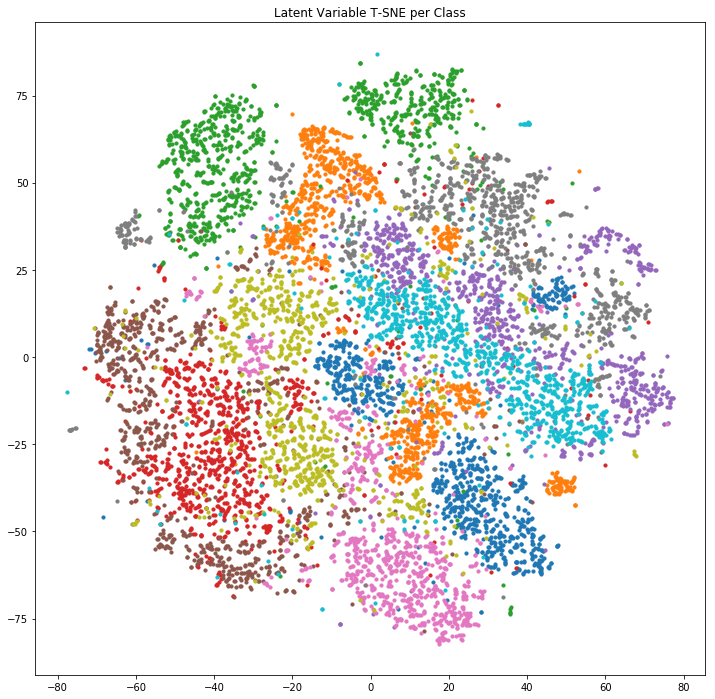

In [6]:
mnist_test_tsne_ssvae(ssvae=ss_vae, test_loader=data_loaders["test"])

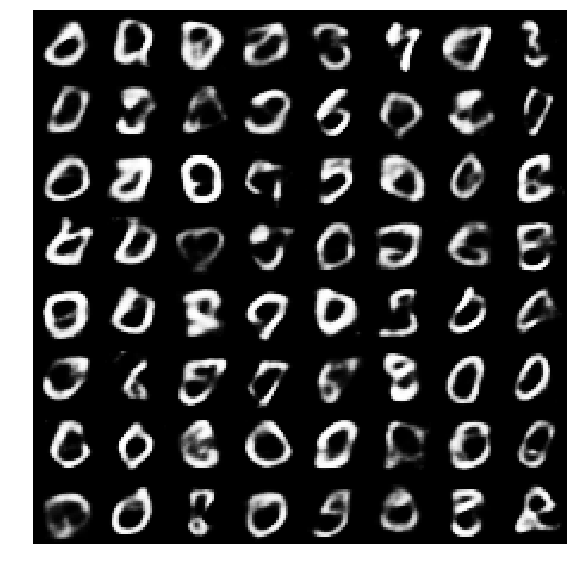

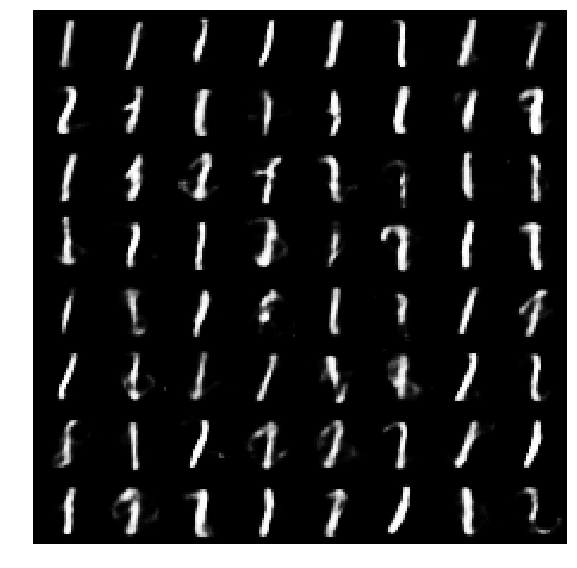

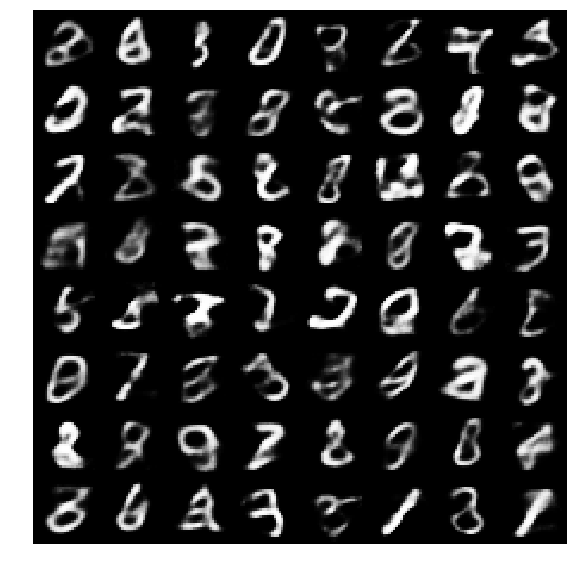

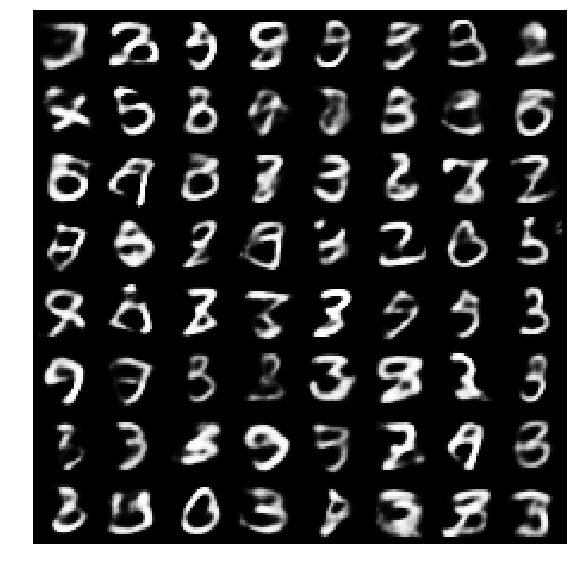

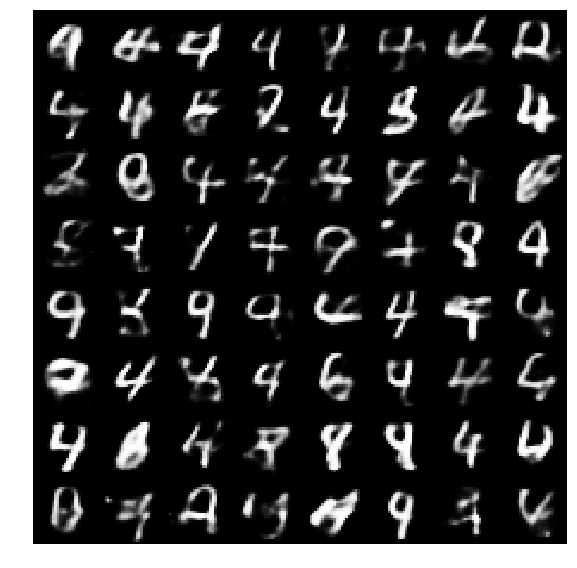

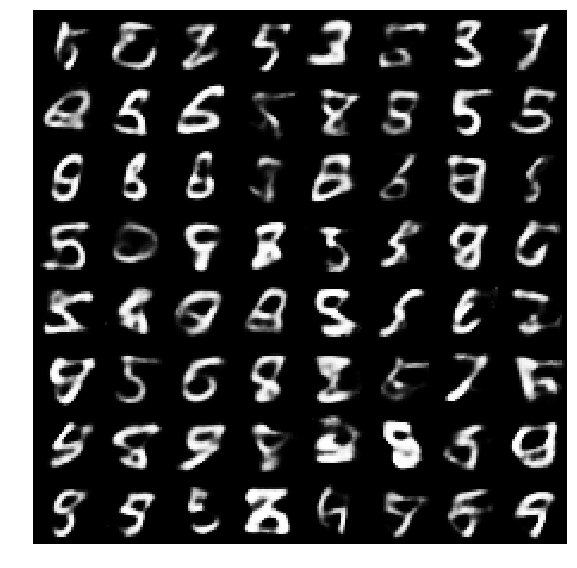

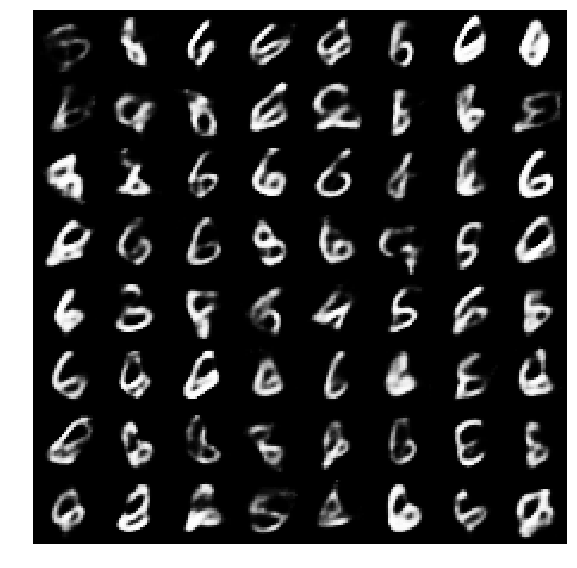

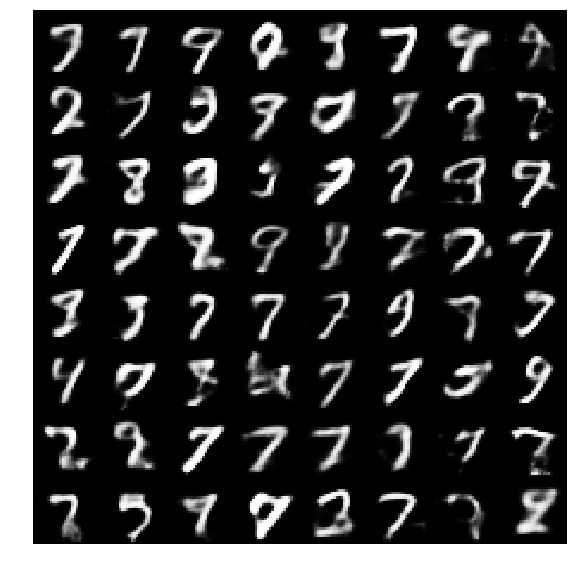

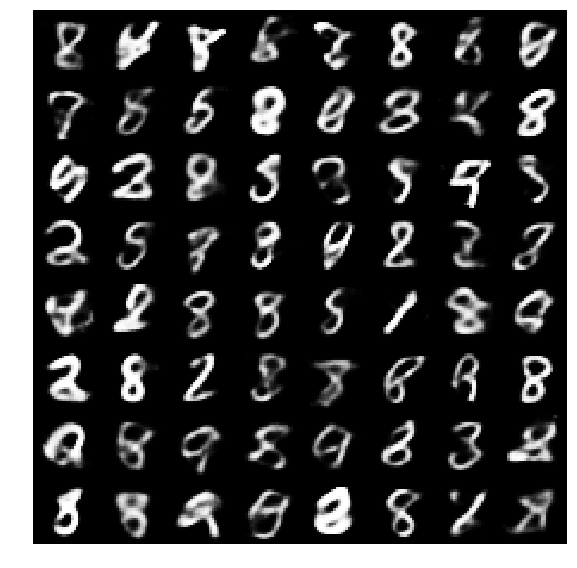

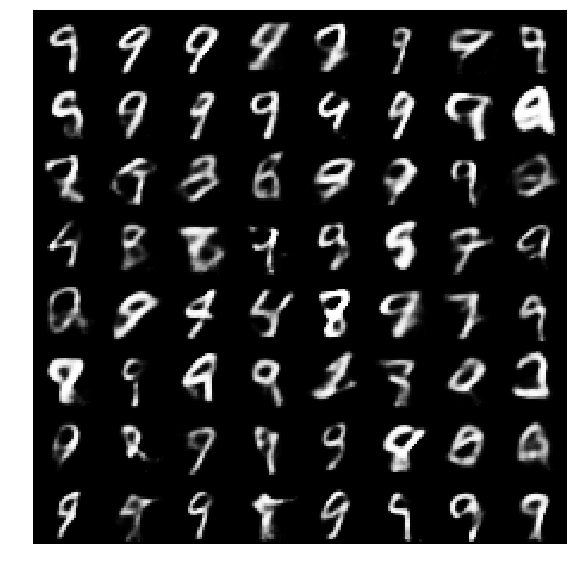

In [7]:
import warnings
warnings.filterwarnings("ignore")

# sampling plot of different styles of a specific class
ys = {}
for i in range(10):
    ys[i] = torch.zeros(1, 10)
    ys[i][0, i] = 1
xs = torch.zeros(1, 784)

ny = nx = 8

for i in range(10):
    images = []
    canvas = np.empty((28*ny, 28*nx))
    
    ind = np.random.randint(0, 9)
    for rr in range(64):
        # get the loc from the model
#         ind = np.random.randint(0, 9)
        sample_loc_i = ss_vae.model(xs, ys[i])
        img = sample_loc_i[0].view(1, 28, 28).cpu().data.numpy()
        k = nx - 1 - rr // nx
        j = rr % ny
        canvas[(nx-k-1)*28:(nx-k)*28, j*28:(j+1)*28] = img.reshape(28, 28)
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.axis('off')
    plt.tight_layout()
    fig.savefig('./vae_results/'+'generating_class_'+str(i)+'.png')

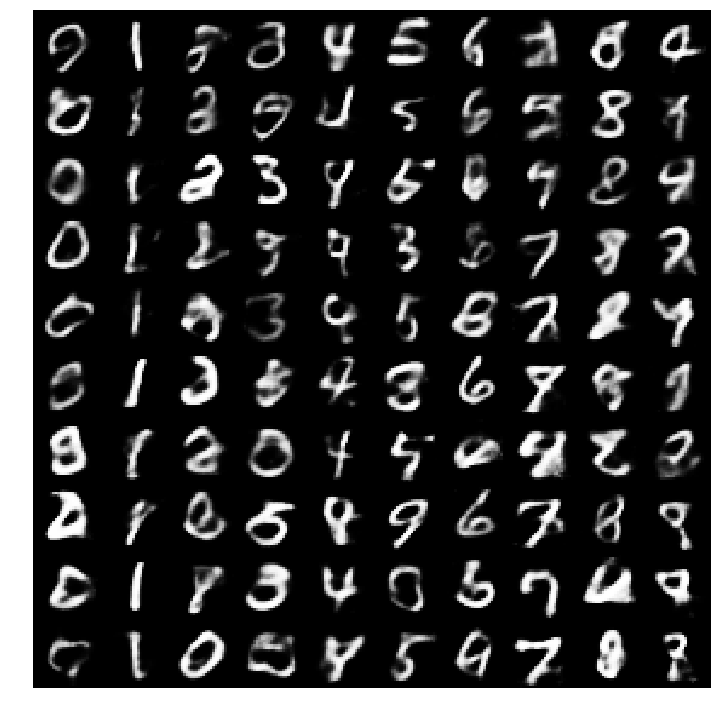

In [8]:
ys = {}
for i in range(10):
    ys[i] = torch.zeros(1, 10)
    ys[i][0, i] = 1
xs = torch.zeros(1, 784)

ny = nx = 10

canvas = np.empty((28*ny, 28*nx))
for i in range(10):
    for rr in range(10):
        sample_loc_i = ss_vae.model(xs, ys[i])
        img = sample_loc_i[0].view(1, 28, 28).cpu().data.numpy()
        k = nx - 1 - rr
        j =  i
        canvas[(nx-k-1)*28:(nx-k)*28, j*28:(j+1)*28] = img.reshape(28, 28)
fig = plt.figure(figsize=(10, 10))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.axis('off')
plt.tight_layout()
fig.savefig('./vae_results/'+'styles_1'+'.png')

4306
6560
8467
3476
4386
4664
6260
7634
6324
5138


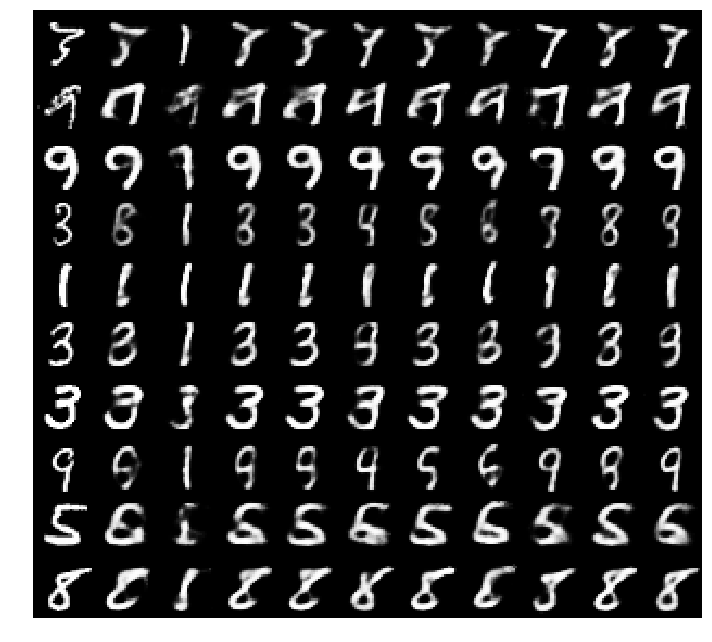

In [12]:
data_test = data_loaders["test"].dataset.test_data.float()

ys = {}
for i in range(10):
    ys[i] = torch.zeros(1, 10)
    ys[i][0, i] = 1
# xs = torch.zeros(1, 784)

ny = nx = 10

canvas = np.empty((28*ny, 28*(nx+1)))
for i in range(10):
    ind = np.random.randint(0, data_test.size(0))
    print(ind)
    xs = data_test[ind]

#     cand = [4665, 7963, 8347, 3012, 7050, 4306, 6324, 4664, 3476, 9020, 8105, 5423, 4386, 
#             8467, 8509, 5905, 2424, 4182, 670, 606, 9020, 9208, 5138, 6260, 216, 6560, 7356, 3781, 3165, 7634]
#     ind = np.random.randint(0, len(cand))
#     print(cand[ind])
#     xs = data_test[cand[ind]]

    zs, z_scale = ss_vae.encoder_z.forward([xs, ys[i]])
# #     loc = self.decoder.forward([zs, ys[i]])
    canvas[i*28:(i+1)*28, 0:28] = xs.numpy().reshape(28, 28)
    for j in range(10):
#         zs, z_scale = ss_vae.encoder_z.forward([xs, ys[j]])
#     loc = self.decoder.forward([zs, ys[i]])
        
#         sample_loc_i = ss_vae.model(xs, ys[i])
        sample_loc = ss_vae.decoder.forward([zs, ys[j]])
        img = sample_loc.view(1, 28, 28).cpu().data.numpy()
        
        canvas[i*28:(i+1)*28, (j+1)*28:(j+2)*28] = img.reshape(28, 28)
fig = plt.figure(figsize=(10, 10))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.axis('off')
plt.tight_layout()
fig.savefig('./vae_results/'+'styles_2'+'.png')